<a href="https://colab.research.google.com/github/jax-md/jax-md/blob/main/notebooks/flocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports & Utils

# Imports
import os

# Check if running in actual Google Colab
IN_COLAB = 'COLAB_RELEASE_TAG' in os.environ
if IN_COLAB:
  !pip install -q --upgrade git+https://www.github.com/google/jax-md

# If you want to run it locally you need to install https://github.com/googlecolab/colabtools.git

import numpy as onp

from jax import config; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import vmap
from jax import lax
vectorize = np.vectorize

from functools import partial

from collections import namedtuple
import base64

import IPython
from google.colab import output

import os

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
from jax_md.util import f32

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')

dark_color = [56 / 256] * 3
light_color = [213 / 256] * 3
axis_color = 'white'

def format_plot(x='', y='', grid=True):
  ax = plt.gca()

  ax.spines['bottom'].set_color(axis_color)
  ax.spines['top'].set_color(axis_color)
  ax.spines['right'].set_color(axis_color)
  ax.spines['left'].set_color(axis_color)

  ax.tick_params(axis='x', colors=axis_color)
  ax.tick_params(axis='y', colors=axis_color)
  ax.yaxis.label.set_color(axis_color)
  ax.xaxis.label.set_color(axis_color)
  ax.set_facecolor(dark_color)

  plt.grid(grid)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().patch.set_facecolor(dark_color)
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Progress Bars

from IPython.display import HTML, display
import time


def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

normalize = lambda v: v / np.linalg.norm(v, axis=1, keepdims=True)

# Rendering

renderer_code = IPython.display.HTML('''
<canvas id="canvas"></canvas>
<script>
  Rg = null;
  Ng = null;

  var current_scene = {
      R: null,
      N: null,
      is_loaded: false,
      frame: 0,
      frame_count: 0,
      boid_vertex_count: 0,
      boid_buffer: [],
      predator_vertex_count: 0,
      predator_buffer: [],
      disk_vertex_count: 0,
      disk_buffer: null,
      box_size: 0
  };

  google.colab.output.setIframeHeight(0, true, {maxHeight: 5000});

  async function load_simulation() {
    buffer_size = 400;
    max_frame = 800;

    result = await google.colab.kernel.invokeFunction(
        'notebook.GetObstacles', [], {});
    data = result.data['application/json'];

    if(data.hasOwnProperty('Disk')) {
      current_scene = put_obstacle_disk(current_scene, data.Disk);
    }

    for (var i = 0 ; i < max_frame ; i += buffer_size) {
      console.log(i);
      result = await google.colab.kernel.invokeFunction(
          'notebook.GetBoidStates', [i, i + buffer_size], {});

      data = result.data['application/json'];
      current_scene = put_boids(current_scene, data);
    }
    current_scene.is_loaded = true;

    result = await google.colab.kernel.invokeFunction(
        'notebook.GetPredators', [], {});
    data = result.data['application/json'];
    if (data.hasOwnProperty('R'))
      current_scene = put_predators(current_scene, data);

    result = await google.colab.kernel.invokeFunction(
          'notebook.GetSimulationInfo', [], {});
    current_scene.box_size = result.data['application/json'].box_size;
  }

  function initialize_gl() {
    const canvas = document.getElementById("canvas");
    canvas.width = 640;
    canvas.height = 640;

    const gl = canvas.getContext("webgl2");

    if (!gl) {
        alert('Unable to initialize WebGL.');
        return;
    }

    gl.viewport(0, 0, gl.drawingBufferWidth, gl.drawingBufferHeight);
    gl.clearColor(0.2, 0.2, 0.2, 1.0);
    gl.enable(gl.DEPTH_TEST);

    const shader_program = initialize_shader(
        gl, VERTEX_SHADER_SOURCE_2D, FRAGMENT_SHADER_SOURCE_2D);
    const shader = {
      program: shader_program,
      attribute: {
          vertex_position: gl.getAttribLocation(shader_program, 'vertex_position'),
      },
      uniform: {
          screen_position: gl.getUniformLocation(shader_program, 'screen_position'),
          screen_size: gl.getUniformLocation(shader_program, 'screen_size'),
          color: gl.getUniformLocation(shader_program, 'color'),
      },
    };
    gl.useProgram(shader_program);

    const half_width = 200.0;

    gl.uniform2f(shader.uniform.screen_position, half_width, half_width);
    gl.uniform2f(shader.uniform.screen_size, half_width, half_width);
    gl.uniform4f(shader.uniform.color, 0.9, 0.9, 1.0, 1.0);

    return {gl: gl, shader: shader};
  }

  var loops = 0;

  function update_frame() {
    gl.clear(gl.COLOR_BUFFER_BIT | gl.DEPTH_BUFFER_BIT);

    if (!current_scene.is_loaded) {
      window.requestAnimationFrame(update_frame);
      return;
    }

    var half_width = current_scene.box_size / 2.;
    gl.uniform2f(shader.uniform.screen_position, half_width, half_width);
    gl.uniform2f(shader.uniform.screen_size, half_width, half_width);

    if (current_scene.frame >= current_scene.frame_count) {
      if (!current_scene.is_loaded) {
        window.requestAnimationFrame(update_frame);
        return;
      }
      loops++;
      current_scene.frame = 0;
    }

    gl.enableVertexAttribArray(shader.attribute.vertex_position);

    gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.boid_buffer[current_scene.frame]);
    gl.uniform4f(shader.uniform.color, 0.0, 0.35, 1.0, 1.0);
    gl.vertexAttribPointer(
      shader.attribute.vertex_position,
      2,
      gl.FLOAT,
      false,
      0,
      0
    );
    gl.drawArrays(gl.TRIANGLES, 0, current_scene.boid_vertex_count);

    if(current_scene.predator_buffer.length > 0)  {
      gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.predator_buffer[current_scene.frame]);
      gl.uniform4f(shader.uniform.color, 1.0, 0.35, 0.35, 1.0);
      gl.vertexAttribPointer(
        shader.attribute.vertex_position,
        2,
        gl.FLOAT,
        false,
        0,
        0
      );
      gl.drawArrays(gl.TRIANGLES, 0, current_scene.predator_vertex_count);
    }

    if(current_scene.disk_buffer) {
      gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.disk_buffer);
      gl.uniform4f(shader.uniform.color, 0.9, 0.9, 1.0, 1.0);
      gl.vertexAttribPointer(
        shader.attribute.vertex_position,
        2,
        gl.FLOAT,
        false,
        0,
        0
      );
      gl.drawArrays(gl.TRIANGLES, 0, current_scene.disk_vertex_count);
    }

    current_scene.frame++;
    if ((current_scene.frame_count > 1 && loops < 5) ||
        (current_scene.frame_count == 1 && loops < 240))
      window.requestAnimationFrame(update_frame);

    if (current_scene.frame_count > 1 && loops == 5 && current_scene.frame < current_scene.frame_count - 1)
      window.requestAnimationFrame(update_frame);
  }

  function put_boids(scene, boids) {
    const R = decode(boids['R']);
    const R_shape = boids['R_shape'];
    const theta = decode(boids['theta']);
    const theta_shape = boids['theta_shape'];

    function index(i, b, xy) {
      return i * R_shape[1] * R_shape[2] + b * R_shape[2] + xy;
    }

    var steps = R_shape[0];
    var boids = R_shape[1];
    var dimensions = R_shape[2];

    if(dimensions != 2) {
      alert('Can only deal with two-dimensional data.')
    }

    // First flatten the data.
    var buffer_data = new Float32Array(boids * 6);
    var size = 8.0;
    for (var i = 0 ; i < steps ; i++) {
      var buffer = gl.createBuffer();
      for (var b = 0 ; b < boids ; b++) {
        var xi = index(i, b, 0);
        var yi = index(i, b, 1);
        var ti = i * boids + b;
        var Nx = size * Math.cos(theta[ti]); //N[xi];
        var Ny = size * Math.sin(theta[ti]); //N[yi];
        buffer_data.set([
          R[xi] + Nx, R[yi] + Ny,
          R[xi] - Nx - 0.5 * Ny, R[yi] - Ny + 0.5 * Nx,
          R[xi] - Nx + 0.5 * Ny, R[yi] - Ny - 0.5 * Nx,
        ], b * 6);
      }
      gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
      gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);

      scene.boid_buffer.push(buffer);
    }
    scene.boid_vertex_count = boids * 3;
    scene.frame_count += steps;
    return scene;
  }

  function put_predators(scene, boids) {
    // TODO: Unify this with the put_boids function.
    const R = decode(boids['R']);
    const R_shape = boids['R_shape'];
    const theta = decode(boids['theta']);
    const theta_shape = boids['theta_shape'];

    function index(i, b, xy) {
      return i * R_shape[1] * R_shape[2] + b * R_shape[2] + xy;
    }

    var steps = R_shape[0];
    var boids = R_shape[1];
    var dimensions = R_shape[2];

    if(dimensions != 2) {
      alert('Can only deal with two-dimensional data.')
    }

    // First flatten the data.
    var buffer_data = new Float32Array(boids * 6);
    var size = 18.0;
    for (var i = 0 ; i < steps ; i++) {
      var buffer = gl.createBuffer();
      for (var b = 0 ; b < boids ; b++) {
        var xi = index(i, b, 0);
        var yi = index(i, b, 1);
        var ti = theta_shape[1] * i + b;
        var Nx = size * Math.cos(theta[ti]);
        var Ny = size * Math.sin(theta[ti]);
        buffer_data.set([
          R[xi] + Nx, R[yi] + Ny,
          R[xi] - Nx - 0.5 * Ny, R[yi] - Ny + 0.5 * Nx,
          R[xi] - Nx + 0.5 * Ny, R[yi] - Ny - 0.5 * Nx,
        ], b * 6);
      }
      gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
      gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);

      scene.predator_buffer.push(buffer);
    }
    scene.predator_vertex_count = boids * 3;
    return scene;
  }

  function put_obstacle_disk(scene, disk) {
    const R = decode(disk.R);
    const R_shape = disk.R_shape;
    const radius = decode(disk.D);
    const radius_shape = disk.D_shape;

    const disk_count = R_shape[0];
    const dimensions = R_shape[1];
    if (dimensions != 2) {
        alert('Can only handle two-dimensional data.');
    }
    if (radius_shape[0] != disk_count) {
        alert('Inconsistent disk radius count found.');
    }
    const segments = 32;

    function index(o, xy) {
        return o * R_shape[1] + xy;
    }

    // TODO(schsam): Use index buffers here.
    var buffer_data = new Float32Array(disk_count * segments * 6);
    for (var i = 0 ; i < disk_count ; i++) {
      var xi = index(i, 0);
      var yi = index(i, 1);
      for (var s = 0 ; s < segments ; s++) {
        const th = 2 * s / segments * Math.PI;
        const th_p = 2 * (s + 1) / segments * Math.PI;
        const rad = radius[i] * 0.8;
        buffer_data.set([
          R[xi], R[yi],
          R[xi] + rad * Math.cos(th), R[yi] + rad * Math.sin(th),
          R[xi] + rad * Math.cos(th_p), R[yi] + rad * Math.sin(th_p),
        ], i * segments * 6 + s * 6);
      }
    }
    var buffer = gl.createBuffer();
    gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
    gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);
    scene.disk_vertex_count = disk_count * segments * 3;
    scene.disk_buffer = buffer;
    return scene;
  }

  // SHADER CODE

  const VERTEX_SHADER_SOURCE_2D = `
    // Vertex Shader Program.
    attribute vec2 vertex_position;

    uniform vec2 screen_position;
    uniform vec2 screen_size;

    void main() {
      vec2 v = (vertex_position - screen_position) / screen_size;
      gl_Position = vec4(v, 0.0, 1.0);
    }
  `;

  const FRAGMENT_SHADER_SOURCE_2D = `
    precision mediump float;

    uniform vec4 color;

    void main() {
      gl_FragColor = color;
    }
  `;

  function initialize_shader(
    gl, vertex_shader_source, fragment_shader_source) {

    const vertex_shader = compile_shader(
      gl, gl.VERTEX_SHADER, vertex_shader_source);
    const fragment_shader = compile_shader(
      gl, gl.FRAGMENT_SHADER, fragment_shader_source);

    const shader_program = gl.createProgram();
    gl.attachShader(shader_program, vertex_shader);
    gl.attachShader(shader_program, fragment_shader);
    gl.linkProgram(shader_program);

    if (!gl.getProgramParameter(shader_program, gl.LINK_STATUS)) {
      alert(
        'Unable to initialize shader program: ' +
        gl.getProgramInfoLog(shader_program)
        );
        return null;
    }
    return shader_program;
  }

  function compile_shader(gl, type, source) {
    const shader = gl.createShader(type);
    gl.shaderSource(shader, source);
    gl.compileShader(shader);

    if (!gl.getShaderParameter(shader, gl.COMPILE_STATUS)) {
      alert('An error occured compiling shader: ' + gl.getShaderInfoLog(shader));
      gl.deleteShader(shader);
      return null;
    }

    return shader;
  }

  // SERIALIZATION UTILITIES
  function decode(sBase64, nBlocksSize) {
    var chrs = atob(atob(sBase64));
    var array = new Uint8Array(new ArrayBuffer(chrs.length));

    for(var i = 0 ; i < chrs.length ; i++) {
      array[i] = chrs.charCodeAt(i);
    }

    return new Float32Array(array.buffer);
  }

  // RUN CELL

  load_simulation();
  gl_and_shader = initialize_gl();
  var gl = gl_and_shader.gl;
  var shader = gl_and_shader.shader;
  update_frame();
</script>
''')

def encode(R):
  return base64.b64encode(onp.array(R, onp.float32).tobytes())

def render(box_size, states, obstacles=None, predators=None):
  if isinstance(states, Boids):
    R = onp.reshape(states.R, (1,) + states.R.shape)
    theta = onp.reshape(states.theta, (1,) + states.theta.shape)
  elif isinstance(states, list):
    if all([isinstance(x, Boids) for x in states]):
      R, theta = zip(*states)
      R = onp.stack(R)
      theta = onp.stack(theta)

  if isinstance(predators, list):
    R_predators, theta_predators, *_ = zip(*predators)
    R_predators = onp.stack(R_predators)
    theta_predators = onp.stack(theta_predators)

  def get_boid_states(start, end):
    R_, theta_ = R[start:end], theta[start:end]
    return IPython.display.JSON(data={
        "R_shape": R_.shape,
        "R": encode(R_),
        "theta_shape": theta_.shape,
        "theta": encode(theta_)
        })
  output.register_callback('notebook.GetBoidStates', get_boid_states)

  def get_obstacles():
    if obstacles is None:
      return IPython.display.JSON(data={})
    else:
      return IPython.display.JSON(data={
          'Disk': {
              'R': encode(obstacles.R),
              'R_shape': obstacles.R.shape,
              'D': encode(obstacles.D),
              'D_shape': obstacles.D.shape
          }
      })
  output.register_callback('notebook.GetObstacles', get_obstacles)

  def get_predators():
    if predators is None:
      return IPython.display.JSON(data={})
    else:
      return IPython.display.JSON(data={
          'R': encode(R_predators),
          'R_shape': R_predators.shape,
          'theta': encode(theta_predators),
          'theta_shape': theta_predators.shape
      })
  output.register_callback('notebook.GetPredators', get_predators)

  def get_simulation_info():
    return IPython.display.JSON(data={
        'frames': R.shape[0],
        'box_size': box_size
        })
  output.register_callback('notebook.GetSimulationInfo', get_simulation_info)

  return renderer_code

  Preparing metadata (setup.py) ... done


#### **Warning**: After running the simulations in this notebook, you have to wait a moment (5 - 30 seconds) for rendering.

# Flocks, Herds, and Schools: A Distributed Behavioral Model

We will go over the paper, ["Flocks, Herds, and Schools: A Distributed Behavioral Model"]((https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E252054B1C02D387E8C20827CB414543?doi=10.1.1.103.7187&rep=rep1&type=pdf)) published by C. W. Reynolds in SIGGRAPH 1987. The paper itself is fantastic and, as far as a description of flocking is concerned, there is little that we can offer. Therefore, rather than go through the paper directly, we will use [JAX](https://www.github.com/google/jax) and [JAX, MD](https://www.github.com/google/jax-md) to interactively build a simulation similar to Reynolds' in colab. To simplify our discussion, we will build a two-dimensional version of Reynolds' simulation.

In nature there are many examples in which large numbers of animals exhibit complex collective motion (schools of fish, flocks of birds, herds of horses, colonies of ants). In his seminal paper, Reynolds introduces a model of such collective behavior (henceforth refered to as "flocking") based on simple rules that can be computed locally for each entity (referred to as a "boid") in the flock based on its environment. This paper is written in the context of computer graphics and so Reynolds is going for biologically inspired simulations that look right rather than accuracy in any statistical sense. Ultimately, Reynolds measures success in terms of "delight" people find in watching the simulations; we will use a similar metric here.

Note, we recommend running this notebook in "Dark" mode.

## Boids

Reynolds is interested in simulating bird-like entities that are described by a position, $R$, and an orientation, $\theta$. This state can optionally augmented with extra information (for example, hunger or fear). We can define a Boids type that stores data for a collection of boids as two arrays. `R` is an `ndarray` of shape `[boid_count, spatial_dimension]` and `theta` is an ndarray of shape `[boid_count]`. An individual boid is an index into these arrays. It will often be useful to refer to the vector orientation of the boid $N = (\cos\theta, \sin\theta)$.

In [2]:
Boids = namedtuple('Boids', ['R', 'theta'])

We can instantiate a collection of boids randomly in a box of side length $L$. We will use [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) for our simulation which means that boids will be able to wrap around the sides of the box. To do this we will use the `space.periodic` command in [JAX, MD](https://github.com/google/jax-md#spaces-spacepy).

In [3]:
# Simulation Parameters:
box_size = 800.0  # A float specifying the side-length of the box.
boid_count = 200  # An integer specifying the number of boids.
dim = 2  # The spatial dimension in which we are simulating.

# Create RNG state to draw random numbers (see LINK).
rng = random.PRNGKey(0)

# Define periodic boundary conditions.
displacement, shift = space.periodic(box_size)

# Initialize the boids.
rng, R_rng, theta_rng = random.split(rng, 3)

boids = Boids(
  R = box_size * random.uniform(R_rng, (boid_count, dim)),
  theta = random.uniform(theta_rng, (boid_count,), maxval=2. * np.pi)
)

In [4]:
display(render(box_size, boids))

## Dynamics

Now that we have defined our boids, we have to imbue them with some rules governing their motion. Reynolds notes that in nature flocks do not seem to have a maximum size, but instead can keep acquiring new boids and grow without bound. He also comments that each boid cannot possibly be keeping track of the entire flock and must, instead, be focusing on its local neighborhood. Reynolds then proposes three simple, local, rules that boids might try to follow:


1.   **Alignment:** Boids will try to align themselves in the direction of their neighbors.
2.   **Avoidance:** Boids will avoid colliding with their neighbors.
3.   **Cohesion:** Boids will try to move towards the center of mass of their neighbors.

In his exposition, Reynolds is vague about the details for each of these rules and so we will take some creative liberties. We will try to phrase this problem as an energy model, so our goal will be to write down an "energy" function (similar to a "loss") $E(R, \theta)$ such that low-energy configurations of boids satisfy each of the three rules above.

\

We will write the total energy as a sum of three terms, one for each of the rules above:

$$E(R, \theta) = E_{\text{Align}}(R, \theta) + E_{\text{Avoid}}(R, \theta) + E_{\text{Cohesion}}(R,\theta)$$

We will go through each of these rules separately below starting with alignment. Of course, any of these terms could be replaced by a learned solution.

\

Once we have an energy defined in this way, configurations of boids that move along low energy trajectories might display behavior that looks appealing. However, we still have a lot of freedom to decide how we want to define dynamics over the boids. Reynolds says he uses overdamped dynamics and so we will do something similar. In particular, we will update the position of the boids so that they try to move to minimize their energy. Simultaneously , we assume that the boids are swimming (or flying / walking). We choose a particularly simple model of this to start with and assume that the boids move at a fixed speed, $v$, along whatever direction they are pointing. We will use simple forward-Euler integration. This gives an update step,

$${R_i}' = R_i + \delta t(v\hat N_i - \nabla_{R_i}E(R, \theta))$$

where $\delta t$ is a timestep that we are allowed to choose. We will often refer to the force, $F^{R_i} = -\nabla_{R_i} E(R, \hat N)$ as the negative gradient of the energy with respect to the position of the $i$'th boid.

\

We will update the orientations of the boids turn them towards "low energy" directions. To do this we will once again use a simple forward-Euler scheme,

$$
\theta'_i = \theta_i - \delta t\nabla_{\theta_i}E(R,\theta)
$$

This is just one choice of dynamics, but there are probably many that would work equally well! Feel free to play around with it. One easy improvement that one could imagine making would be to use a more sophisticated integrator. We include a Runge-Kutta 4 integrator at the top of the notebook for an adventurous reader.

\

To see what this looks like before we define any interactions, we can run a simulation with $E(R,\theta) = 0$ by first defining an `update` function that takes a boids state to a new boids state.

In [5]:
@vmap
def normal(theta):
  return np.array([np.cos(theta), np.sin(theta)])

def dynamics(energy_fn, dt, speed):
  @jit
  def update(_, state):
    R, theta = state['boids']

    dstate = quantity.force(energy_fn)(state)
    dR, dtheta = dstate['boids']
    n = normal(state['boids'].theta)

    state['boids'] = Boids(shift(R, dt * (speed * n + dR)),
                           theta + dt * dtheta)

    return state

  return update

Now we can run a simulation and save the boid positions to a `boids_buffer` which will just be a list.

In [6]:
update = dynamics(energy_fn=lambda state: 0., dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size, boids_buffer))

### Alignment

While the above simulation works and our boids are moving happily along, it is not terribly interesting. The first thing that we can add to this simulation is the alignment rule. When writing down these rules, it is often easier to express them for a single pair of boids and then use JAX's [automatic vectorization](https://github.com/google/jax#auto-vectorization-with-vmap) via `vmap` to extend them to our entire simulation.

Given a pair of boids $i$ and $j$ we would like to choose an energy function that is minimized when they are pointing in the same direction. As discussed above, one of Reynolds' requirements was locality: boids should only interact with nearby boids. To do this, we introduce a cutoff $D_{\text{Align}}$ and ignore pairs of boids such that $\|\Delta R_{ij}\| > D_{\text{Align}}$ where $\Delta R_{ij} = R_i - R_j$. To make it so boids react smoothly we will have the energy start out at zero when $\|R_i - R_j\| = D_{\text{Align}}$ and increase smoothly as they get closer. Together, these simple ideas lead us to the following proposal,

$$\epsilon_{\text{Align}}(\Delta R_{ij}, \hat N_i, \hat N_j) = \begin{cases}\frac{J_{\text{Align}}}\alpha\left (1 - \frac{\|\Delta R_{ij}\|}{D_{\text{Align}}}\right)^\alpha(1 - \hat N_1 \cdot \hat N_2)^2 & \text{if $\|\Delta R_{ij}\| < D$}\\ 0 & \text{otherwise}\end{cases}$$

This energy will be maximized when $N_1$ and $N_2$ are anti-aligned and minimized when $N_1 = N_2$. In general, we would like our boids to turn to align themselves with their neighbors rather than shift their centers to move apart. Therefore, we'll insert a stop-gradient into the displacement.

In [7]:
def align_fn(dR, N_1, N_2, J_align, D_align, alpha):
  dR = lax.stop_gradient(dR)
  dr = space.distance(dR) / D_align
  energy = J_align / alpha * (1. - dr) ** alpha * (1 - np.dot(N_1, N_2)) ** 2
  return np.where(dr < 1.0, energy, 0.)

We can plot the energy for different alignments as well as different distances between boids. We see that the energy goes to zero for large distances and when the boids are aligned.

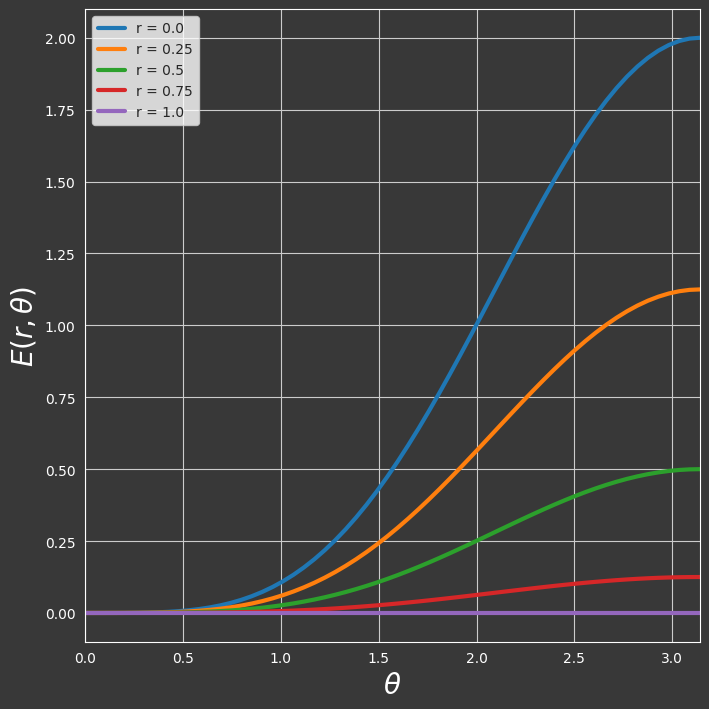

In [8]:
#@title Alignment Energy
N_1 = np.array([1.0, 0.0])
angles = np.linspace(0, np.pi, 60)
N_2 = vmap(lambda theta: np.array([np.cos(theta), np.sin(theta)]))(angles)
distances = np.linspace(0, 1, 5)
dRs = vmap(lambda r: np.array([r, 0.]))(distances)

fn = partial(align_fn, J_align=1., D_align=1., alpha=2.)
energy = vmap(vmap(fn, (None, None, 0)), (0, None, None))(dRs, N_1, N_2)

for d, e in zip(distances, energy):
  plt.plot(angles, e, label='r = {}'.format(d), linewidth=3)

plt.xlim([0, np.pi])
format_plot('$\\theta$', '$E(r, \\theta)$')
plt.legend()
finalize_plot()

We can now our simulation with the alignment energy alone.

In [9]:
def energy_fn(state):
  boids = state['boids']
  E_align = partial(align_fn, J_align=0.5, D_align=45., alpha=3.)
  # Map the align energy over all pairs of boids. While both applications
  # of vmap map over the displacement matrix, each acts on only one normal.
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  dR = space.map_product(displacement)(boids.R, boids.R)
  N = normal(boids.theta)

  return 0.5 * np.sum(E_align(dR, N, N))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size, boids_buffer))

Now the boids align with one another and already the simulation is displaying interesting behavior!

### Avoidance

We can incorporate an avoidance rule that will keep the boids from bumping into one another. This will help them to form a flock with some volume rather than collapsing together. To this end, imagine a very simple model of boids that push away from one another if they get within a distance $D_{\text{Avoid}}$ and otherwise don't repel. We can use a simple energy similar to Alignment but without any angular dependence,

$$
\epsilon_{\text{Avoid}}(\Delta R_{ij}) = \begin{cases}\frac{J_{\text{Avoid}}}{\alpha}\left(1 - \frac{||\Delta R_{ij}||}{D_{\text{Avoid}}}\right)^\alpha & ||\Delta R_{ij}||<D_{\text{Avoid}} \\ 0 & \text{otherwise}\end{cases}
$$

This is implemented in the following Python function. Unlike the case of alignment, here we want boids to move away from one another and so we don't need a stop gradient on $\Delta R$.

In [10]:
def avoid_fn(dR, J_avoid, D_avoid, alpha):
  dr = space.distance(dR) / D_avoid
  return np.where(dr < 1.,
                  J_avoid / alpha * (1 - dr) ** alpha,
                  0.)

Plotting the energy we see that it is highest when boids are overlapping and then goes to zero smoothly until $||\Delta R|| = D_{\text{Align}}$.

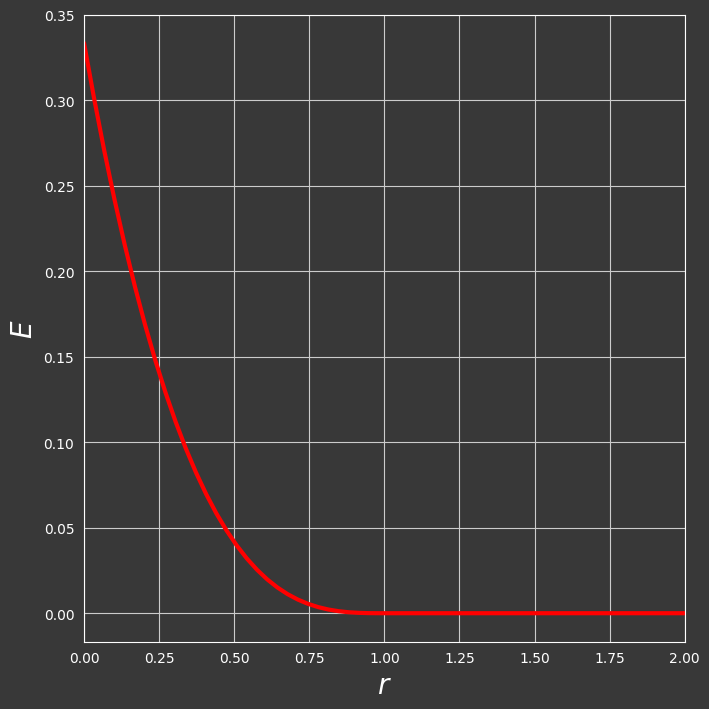

In [11]:
#@title Avoidance Energy

dr = np.linspace(0, 2., 60)
dR = vmap(lambda r: np.array([0., r]))(dr)
Es = vmap(partial(avoid_fn, J_avoid=1., D_avoid=1., alpha=3.))(dR)
plt.plot(dr, Es, 'r', linewidth=3)

plt.xlim([0, 2])

format_plot('$r$', '$E$')
finalize_plot()

We can now run a version of our simulation with both alignment and avoidance.

In [12]:
def energy_fn(state):
  boids = state['boids']

  E_align = partial(align_fn, J_align=1., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  # New Avoidance Code
  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))
  #

  dR = space.map_product(displacement)(boids.R, boids.R)
  N = normal(boids.theta)

  return 0.5 * np.sum(E_align(dR, N, N) + E_avoid(dR))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size,  boids_buffer))

The avoidance term in the energy stops the boids from collapsing on top of one another.

### Cohesion



The final piece of Reynolds' boid model is cohesion. Notice that in the above simulation, the boids tend to move in the same direction but they also often drift apart. To make the boids behave more like schools of fish or birds, which maintain a more compact arrangement, we add a cohesion term to the energy.

The goal of the cohesion term is to align boids towards the center of mass of their neighbors. Given a boid, $i$, we can compute the center of mass position of its neighbors as,

$$
\Delta R_i = \frac 1{|\mathcal N|} \sum_{j\in\mathcal N}\Delta R_{ij}
$$

where we have let $\mathcal N$ be the set of boids such that $||\Delta R_{ij}|| < D_{\text{Cohesion}}$.

Given the center of mass displacements, we can define a reasonable cohesion energy as,

$$
\epsilon_{Cohesion}\left(\widehat{\Delta R}_i, N_i\right) = \frac12J_{\text{Cohesion}}\left(1 - \widehat {\Delta R}_i\cdot N\right)^2
$$

where $\widehat{\Delta R}_i = \Delta R_i / ||\Delta R_i||$ is the normalized vector pointing in the direction of the center of mass. This function is minimized when the boid is pointing in the direction of the center of  mass.

We can implement the cohesion energy in the following python function. Note that as with alignment, we will have boids control their orientation and so we will insert a stop gradient on the displacement vector.


In [13]:
def cohesion_fn(dR, N, J_cohesion, D_cohesion, eps=1e-7):
  dR = lax.stop_gradient(dR)
  dr = np.linalg.norm(dR, axis=-1, keepdims=True)

  mask = dr < D_cohesion

  N_com = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = np.sum(dR_com, axis=1) / (np.sum(N_com, axis=1) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, axis=1, keepdims=True)
  return f32(0.5) * J_cohesion * (1 - np.sum(dR_com * N, axis=1)) ** 2

In [14]:
def energy_fn(state):
  boids = state['boids']

  E_align = partial(align_fn, J_align=1., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  # New Cohesion Code
  E_cohesion = partial(cohesion_fn, J_cohesion=0.005, D_cohesion=40.)
  #

  dR = space.map_product(displacement)(boids.R, boids.R)
  N = normal(boids.theta)

  return (0.5 * np.sum(E_align(dR, N, N) + E_avoid(dR)) +
          np.sum(E_cohesion(dR, N)))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size,  boids_buffer))

Now the boids travel in tighter, more cohesive, packs. By tuning the range of the cohesive interaction and its strength you can change how strongly the boids attempt to stick together. However, if we raise it too high it can have some undesireable consequences.

In [15]:
def energy_fn(state):
  boids = state['boids']

  E_align = partial(align_fn, J_align=1., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  E_cohesion = partial(cohesion_fn, J_cohesion=0.1, D_cohesion=40.)  # Raised to 0.05.

  dR = space.map_product(displacement)(boids.R, boids.R)
  N = normal(boids.theta)

  return (0.5 * np.sum(E_align(dR, N, N) + E_avoid(dR)) +
          np.sum(E_cohesion(dR, N)))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size,  boids_buffer))

### Looking Ahead

When the effect of cohesion is set to a large value, the boids cluster well. However, the motion of the individual flocks becomes less smooth and adopts an almost oscillatory behavior. This is caused by boids in the front of the pack getting pulled towards boids behind them.

To improve this situation, we follow Reynolds and note that animals don't really look in all directions. The behavior of our flocks might look more realistic if we encorporated "field of view" for the boids. To this end, in both the alignment function and the cohesion function we will ignore boids that are outside of the line of sight for the boid. We will have a particularly simple definition for line of sight by first defining, $\widehat{\Delta R_{ij}} \cdot N_i = \cos\theta_{ij}$ where $\theta_{ij}$ is the angle between the orientation of the boid and the vector from the boid to its neighbor.

Since most animals that display flocking behavior have eyes in the side of their head, as opposed to the front, we will define $\theta_{\text{min}}$ and $\theta_{\text{max}}$ to bound the angular field of view of the boids. Then, we assume each boid can see neighbors if $\cos\theta_{\text{min}} < \cos\theta < \cos\theta_\text{max}$.

In [16]:
def field_of_view_mask(dR, N, theta_min, theta_max):
  dr = space.distance(dR)
  dR_hat = dR / dr
  ctheta = np.dot(dR_hat, N)
  # Cosine is monotonically decreasing on [0, pi].
  return np.logical_and(ctheta > np.cos(theta_max),
                        ctheta < np.cos(theta_min))

We can then adapt the cohesion function to incorporate an arbitrary mask,

In [17]:
def cohesion_fn(dR, N, mask, # New mask parameter.
                J_cohesion, D_cohesion, eps=1e-7):
  dR = lax.stop_gradient(dR)
  dr = space.distance(dR)

  mask = np.reshape(mask, mask.shape + (1,))
  dr = np.reshape(dr, dr.shape + (1,))

  # Updated Masking Code
  mask = np.logical_and(dr < D_cohesion, mask)
  #

  N_com = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = np.sum(dR_com, axis=1) / (np.sum(N_com, axis=1) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, axis=1, keepdims=True)
  return f32(0.5) * J_cohesion * (1 - np.sum(dR_com * N, axis=1)) ** 2

And finally run a simulation incorporating the field of view.

In [18]:
def energy_fn(state):
  boids = state['boids']

  E_align = partial(align_fn, J_align=12., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  E_cohesion = partial(cohesion_fn, J_cohesion=0.05, D_cohesion=40.)

  dR = space.map_product(displacement)(boids.R, boids.R)
  N = normal(boids.theta)

  # New FOV code.
  fov = partial(field_of_view_mask,
                theta_min=0.,
                theta_max=np.pi / 3.)
  # As before, we have to vmap twice over the displacement matrix, but only once
  # over the normal.
  fov = vmap(vmap(fov, (0, None)))
  mask = fov(dR, N)
  #

  return (0.5 * np.sum(E_align(dR, N, N) * mask + E_avoid(dR)) +
          np.sum(E_cohesion(dR, N, mask)))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size,  boids_buffer))

## Extras

Now that the core elements of the simulation are working well enough, we can add some extras fairly easily. In particular, we'll try to add some obstacles and some predators.



### Obstacles

The first thing we'll add are obstacles that the boids and (soon) the predators will try to avoid as they wander around the simulation. For the purposes of this notebook, we'll restrict ourselves to disk-like obstacles. Each disk will be described by a center position and a radius, $D_\text{Obstacle}$.

In [19]:
Obstacle = namedtuple('Obstacle', ['R', 'D'])

Then we can instantiate some obstacles.

In [20]:
N_obstacle = 5

R_rng, D_rng = random.split(random.PRNGKey(5))
obstacles = Obstacle(
    box_size * random.uniform(R_rng, (N_obstacle, 2)),
    random.uniform(D_rng, (N_obstacle,), minval=30.0, maxval=100.0)
)

In a similar spirit to the energy functions above, we would like an energy function that encourages the boids to avoid obstacles. For this purpose we will pick an energy function that is similar in form to the alignment function above,

$$
\epsilon_\text{Obstacle}(\Delta R_{io}, N_i, D_o) =  \begin{cases}\frac{J_\text{Obstacle}}{\alpha}\left(1 - \frac{\|\Delta R_{io}\|}{D_o}\right)^\alpha\left(1 + N_i\cdot \widehat{\Delta R_{io}}\right)^2 & \|\Delta R_{io}\| < D_o \\ 0 & \text{Otherwise}\end{cases}
$$

for $\Delta R_{io}$ the displacement vector between a boid $i$ and an obstacle $o$. This energy is zero when the boid and the obstacle are not overlapping. When they are overlapping, the energy is minimized when the boid is facing away from the obstacle.

\

We can write down the boid-energy function in python.


In [21]:
def obstacle_fn(dR, N, D, J_obstacle):
  dr = space.distance(dR)
  dR = dR / np.reshape(dr, dr.shape + (1,))
  return np.where(dr < D,
                  J_obstacle * (1 - dr / D) ** 2 * (1 + np.dot(N, dR)) ** 2,
                  0.)


Now we can run a simulation that includes obstacles.

In [22]:
def energy_fn(state):
  boids = state['boids']
  d = space.map_product(displacement)

  E_align = partial(align_fn, J_align=12., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  E_cohesion = partial(cohesion_fn, J_cohesion=0.05, D_cohesion=40.)

  dR = d(boids.R, boids.R)
  N = normal(boids.theta)

  fov = partial(field_of_view_mask,
                theta_min=0.,
                theta_max=np.pi / 3.)
  fov = vmap(vmap(fov, (0, None)))
  mask = fov(dR, N)

  # New obstacle code
  obstacles = state['obstacles']
  dR_o = -d(boids.R, obstacles.R)
  D = obstacles.D
  E_obstacle = partial(obstacle_fn, J_obstacle=1000.)
  E_obstacle = vmap(vmap(E_obstacle, (0, 0, None)), (0, None, 0))
  #

  return (0.5 * np.sum(E_align(dR, N, N) * mask + E_avoid(dR)) +
          np.sum(E_cohesion(dR, N, mask)) + np.sum(E_obstacle(dR_o, N, D)))

update = dynamics(energy_fn=energy_fn, dt=1e-1, speed=1.)

boids_buffer = []

state = {
    'boids': boids,
    'obstacles': obstacles
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]

display(render(box_size,  boids_buffer, obstacles))

The boids are now successfully navigating obstacles in their environment.

### Predators

Next we are going to introduce some predators into the environment for the boids to run away from. Much like the boids, the predators will be described by a position and an angle.

In [23]:
Predator = namedtuple('Predator', ['R', 'theta'])

In [24]:
predators = Predator(R=np.array([[box_size / 2., box_size /2.]]),
                     theta=np.array([0.0]))

The predators will also follow similar dynamics to the boids, swimming in whatever direction they are pointing at some speed that we can choose. Unlike in the previous versions of the simulation, predators naturally introduce some asymmetry to the system. In particular, we would like the boids to flee from the predators, but we want the predators to chase the boids. To achieve this behavior, we will consider a system reminiscient of a two-player game in which the boids move to minize an energy,

$$
E_\text{Boid} = E_\text{Align} + E_\text{Avoid} + E_\text{Cohesion} + E_\text{Obstacle} + E_\text{Boid-Predator}.
$$

Simultaneously, the predators move in an attempt to minimize a simpler energy,

$$
E_\text{Predator} = E_\text{Predator-Boid} + E_\text{Obstacle}.
$$

To add predators to the environment we therefore need to add two rules, one that dictates the boids behavior near a predator and one for the behavior of predators near a group of boids. In both cases we will see that we can draw significant inspiration from behaviors that we've already developed.

\

We will start with the boid-predator function since it is a bit simpler. In fact, we can use an energy that is virtually identical to the obstacle avoidance energy since the desired behavior is the same.

$$
\epsilon_\text{Boid-Predator}(\Delta R_{ip}, N_i) = \frac{J_\text{Boid-Predator}}\alpha\left(1 - \frac{\|\Delta R_{ip}\|}{D_\text{Boid-Predator}}\right)^\alpha (1 + \widehat{\Delta R_{ip}}\cdot N_i)^2
$$

As before, this function is minimized when the boid is pointing away from the predators. Because we don't want the predators to experience this term we must include a stop-gradient on the predator positions.


In [25]:
def boid_predator_fn(R_boid, N_boid, R_predator, J, D, alpha):
  N = N_boid
  dR = displacement(lax.stop_gradient(R_predator), R_boid)
  dr = np.linalg.norm(dR, keepdims=True)
  dR_hat = dR / dr
  return np.where(dr < D,
                  J / alpha * (1 - dr / D) ** alpha * (1 + np.dot(dR_hat, N)),
                  0.)

For the predator-boid function we can borrow the cohesion energy that we developed above to have predators that turn towards the center-of-mass of boids in their field of view.

In [26]:
def predator_boid_fn(R_predator, N_predator, R_boids, J, D, eps=1e-7):
  # It is most convenient to define the predator_boid energy function
  # for a single predator and a whole flock of boids. As such we expect shapes,
  #   R_predator : (spatial_dim,)
  #   N_predator : (spatial_dim,)
  #   R_boids    : (n, spatial_dim,)

  N = N_predator

  # As such, we need to vectorize over the boids.
  d = vmap(displacement, (0, None))
  dR = d(lax.stop_gradient(R_boids), R_predator)
  dr = space.distance(dR)

  fov = partial(field_of_view_mask,
                theta_min=0.,
                theta_max=np.pi / 3.)
  # Here as well.
  fov = vmap(fov, (0, None))

  mask = np.logical_and(dr < D, fov(dR, N))
  mask = mask[:, np.newaxis]

  boid_count = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = np.sum(dR_com, axis=0) / (np.sum(boid_count, axis=0) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, keepdims=True)
  return f32(0.5) * J * (1 - np.dot(dR_com, N)) ** 2

Now we can modify our dynamics to also update predators.

In [27]:
def dynamics(energy_fn, dt, boid_speed, predator_speed):
  # We extract common movement functionality into a `move` function.
  def move(boids, dboids, speed):
    R, theta, *_ = boids
    dR, dtheta = dboids
    n = normal(theta)

    return (shift(R, dt * (speed * n + dR)),
            theta + dt * dtheta)

  @jit
  def update(_, state):
    dstate = quantity.force(energy_fn)(state)

    state['boids'] = Boids(*move(state['boids'], dstate['boids'], boid_speed))
    state['predators'] = Predator(*move(state['predators'],
                                        dstate['predators'],
                                        predator_speed))

    return state

  return update

Finally, we can put everything together and run the simulation.

In [28]:
def energy_fn(state):
  boids = state['boids']
  d = space.map_product(displacement)

  E_align = partial(align_fn, J_align=12., D_align=45., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)), (0, 0, None))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  E_cohesion = partial(cohesion_fn, J_cohesion=0.05, D_cohesion=40.)

  dR = d(boids.R, boids.R)
  N = normal(boids.theta)

  fov = partial(field_of_view_mask,
                theta_min=0.,
                theta_max=np.pi / 3.)
  fov = vmap(vmap(fov, (0, None)))
  mask = fov(dR, N)

  obstacles = state['obstacles']
  dR_bo = -d(boids.R, obstacles.R)
  D = obstacles.D
  E_obstacle = partial(obstacle_fn, J_obstacle=1000.)
  E_obstacle = vmap(vmap(E_obstacle, (0, 0, None)), (0, None, 0))

  # New predator code.
  predators = state['predators']
  E_boid_predator = partial(boid_predator_fn, J=256.0, D=75.0, alpha=3.)
  E_boid_predator = vmap(vmap(E_boid_predator, (0, 0, None)), (None, None, 0))

  N_predator = normal(predators.theta)
  E_predator_boid = partial(predator_boid_fn, J=0.1, D=95.0)
  E_predator_boid = vmap(E_predator_boid, (0, 0, None))

  dR_po = -d(predators.R, obstacles.R)
  #

  E_boid = (0.5 * np.sum(E_align(dR, N, N) * mask + E_avoid(dR)) +
            np.sum(E_cohesion(dR, N, mask)) + np.sum(E_obstacle(dR_bo, N, D)) +
            np.sum(E_boid_predator(boids.R, N, predators.R)))

  E_predator = (np.sum(E_obstacle(dR_po, N_predator, D)) +
                 np.sum(E_predator_boid(predators.R, N_predator, boids.R)))

  return E_boid + E_predator

update = dynamics(energy_fn=energy_fn, dt=1e-1, boid_speed=1., predator_speed=.85)

boids_buffer = []
predators_buffer = []

state = {
    'boids': boids,
    'obstacles': obstacles,
    'predators': predators
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]
  predators_buffer += [state['predators']]

display(render(box_size,  boids_buffer, obstacles, predators_buffer))

We see that our predator now moves around chasing the boids.

### Internal State

Until now, all of the data describing the boids, predators, and obstacles referred to their physical location and orientation. However, we can develop more interesting behavior if we allow the agents in our simulation to have extra data describing their internal state. As an example of this, we will allow predators to accelerate to chase boids if they get close.

\

To this end, we add at extra piece of data to our predator, $t_\text{sprint}$ which is the last time the predator accelerated. If the predator gets within $D_\text{sprint}$ of a boid and it has been at least $T_\text{sprint}$ units of time since it last sprinted it will accelerate. In practice, to accelerate the predator we will adjust its speed so that,

$$
s(t) = s_0 + s_1 e^{-(t - t_\text{sprint}) / C\tau_\text{sprint}}
$$

where $s_0$ is the normal speed of the predator, $s_0 + s_1$ is the peak speed, and $\tau_\text{sprint}$ determines how long the sprint lasts for. In practice, rather than storign $t_\text{sprint}$ we will record $\Delta t = t - t_\text{sprint}$ which is the time since the last sprint.

\

Implementing this first requires that we add the necessary data to the predators.

In [29]:
Predator = namedtuple('Predator', ['R', 'theta', 'dt'])

In [30]:
predators = Predator(R=np.array([[box_size / 2., box_size /2.]]),
                     theta=np.array([0.0]),
                     dt=np.array([0.]))

In [31]:
def dynamics(energy_fn, dt, boid_speed, predator_speed):
  # We extract common movement functionality into a `move` function.
  def move(boids, dboids, speed):
    R, theta, *_ = boids
    dR, dtheta, *_ = dboids
    n = normal(theta)

    return (shift(R, dt * (speed * n + dR)),
            theta + dt * dtheta)

  @jit
  def update(_, state):
    dstate = quantity.force(energy_fn)(state)

    state['boids'] = Boids(*move(state['boids'], dstate['boids'], boid_speed))

    # New code to accelerate the predators.
    D_sprint = 65.
    T_sprint = 300.
    tau_sprint = 50.
    sprint_speed = 2.0

    # First we find the distance from each predator to the nearest boid.
    d = space.map_product(space.metric(displacement))
    predator = state['predators']
    dr_min = np.min(d(state['boids'].R, predator.R), axis=1)

    # Check whether there is a near enough boid to bother sprinting and if
    # enough time has elapsed since the last sprint.
    mask = np.logical_and(dr_min < D_sprint, predator.dt > T_sprint)
    predator_dt = np.where(mask, 0., predator.dt + dt)

    # Adjust the speed according to whether or not we're sprinting.
    speed = predator_speed + sprint_speed * np.exp(-predator_dt / tau_sprint)

    predator_R, predator_theta = move(state['predators'],
                                      dstate['predators'],
                                      speed)
    state['predators'] = Predator(predator_R, predator_theta, predator_dt)
    #

    return state

  return update

In [32]:
update = dynamics(energy_fn=energy_fn, dt=1e-1, boid_speed=1., predator_speed=.85)

boids_buffer = []
predators_buffer = []

state = {
    'boids': boids,
    'obstacles': obstacles,
    'predators': predators
}

for i in ProgressIter(range(400)):
  state = lax.fori_loop(0, 50, update, state)
  boids_buffer += [state['boids']]
  predators_buffer += [state['predators']]

display(render(box_size,  boids_buffer, obstacles, predators_buffer))

## Scaling Up

Up to this point, we have simulated a relatively small flock of $n = 200$ boids. In part we have done this because we compute, at each step, an $n\times n$ matrix of distances. Therefore the computational complexity of the flocking simulation scales as $\mathcal O(n^2)$. However, as Reynolds' notes we have built in a locality assumption so that no boids interact provided they are further apart than $D =\max\{D_{\text{Align}}, D_\text{Avoid}, D_\text{Cohesion}\}$. JAX MD provides tools to construct a set of candidates for each boid in about $\mathcal O(n\log n)$ time by predcomputing a list of neighbors for each boid. Using neighbor lists we can scale to much larger simulations.

We create lists of all neighbors within a distance of $D + \delta$ and pack them into an array of shape $n\times n_\text{max\_neighbors}$. Using this technique we only need to rebuild the neighbor list if any particle has moved more than a distance of $\delta$. We estimate `max_neighbors` from arrangements of particles and if any boid ever has more than this number of neighbors we must rebuild the neighbor list from scratch and recompile our simulation onto device.  

To start with we setup a much larger system of boids.

In [33]:
# Simulation Parameters.
box_size = 2400.0  # A float specifying the side-length of the box.
boid_count = 2000  # An integer specifying the number of boids.
obstacle_count = 10 # An integer specifying the number of obstacles.
predator_count = 10 # An integer specifying the number of predators.
dim = 2  # The spatial dimension in which we are simulating.

# Create RNG state to draw random numbers.
rng = random.PRNGKey(0)

# Define periodic boundary conditions.
displacement, shift = space.periodic(box_size)

# Initialize the boids.
# To generate normal vectors that are uniformly distributed on S^N note that
# one can generate a random normal vector in R^N and then normalize it.
rng, R_rng, theta_rng = random.split(rng, 3)

boids = Boids(
  R = box_size * random.uniform(R_rng, (boid_count, dim)),
  theta = random.uniform(theta_rng, (boid_count,), maxval=2 * np.pi)
)

rng, R_rng, D_rng = random.split(rng, 3)
obstacles = Obstacle(
    R = box_size * random.uniform(R_rng, (obstacle_count, dim)),
    D = random.uniform(D_rng, (obstacle_count,), minval=100, maxval=300.)
)

rng, R_rng, theta_rng = random.split(rng, 3)
predators = Predator(
    R = box_size * random.uniform(R_rng, (predator_count, dim)),
    theta = random.uniform(theta_rng, (predator_count,), maxval=2 * np.pi),
    dt = np.zeros((predator_count,))
)


In [34]:
neighbor_fn = partition.neighbor_list(displacement,
                                      box_size,
                                      r_cutoff=45.,
                                      dr_threshold=10.,
                                      capacity_multiplier=1.5,
                                      format=partition.Sparse)

neighbors = neighbor_fn.allocate(boids.R)
print(neighbors.idx.shape)

/usr/local/lib/python3.12/dist-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


(2, 9846)


We see that dispite having 2000 boids, they each only have about 13 neighbors apiece at the start of the simulation. Of course this will grow over time and we will have to rebuild the neighbor list as it does. Next we make some minimal modifications to our energy function to rewrite the energy of our simulation to operate on neighbors. This mostly involves changing some of the vectorization patterns with `vmap` and creating a mask of which neighbors in the $n\times n_\text{max neighbors}$ arrays are filled. Finally, we have to make a slightly updated version of the cohesion function that takes into account the neighbors.

In [35]:
from jax import ops

def cohesion_fn(dR, N, mask, # New mask parameter.
                neighbor, J_cohesion, D_cohesion, eps=1e-7):
  dR = lax.stop_gradient(dR)
  dr = space.distance(dR)

  count = len(neighbor.reference_position)
  mask = np.reshape(mask, mask.shape + (1,))
  dr = np.reshape(dr, dr.shape + (1,))

  mask = (dr < D_cohesion) & mask

  N_com = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = ops.segment_sum(dR_com, neighbor.idx[0], count)
  dR_com /= (ops.segment_sum(N_com, neighbor.idx[0], count) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, axis=1, keepdims=True)
  return f32(0.5) * J_cohesion * (1 - np.sum(dR_com * N, axis=1)) ** 2

def energy_fn(state, neighbors):
  boids = state['boids']
  d = space.map_product(displacement)

  fov = partial(field_of_view_mask,
                theta_min=0.,
                theta_max=np.pi / 3.)
  fov = vmap(fov)

  E_align = partial(align_fn, J_align=12., D_align=45., alpha=3.)
  E_align = vmap(E_align)

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(E_avoid)

  E_cohesion = partial(cohesion_fn, neighbor=neighbors,
                       J_cohesion=0.05, D_cohesion=40.)

  # New code to extract displacement vector to neighbors and normals.
  senders, receivers = neighbors.idx
  Ra = boids.R[senders]
  Rb = boids.R[receivers]

  dR = -space.map_bond(displacement)(Ra, Rb)
  N = normal(boids.theta)
  Na, Nb = N[senders], N[receivers]
  #

  # New code to add a mask over neighbors as well as field-of-view.
  neighbor_mask = partition.neighbor_list_mask(neighbors)
  fov_mask = np.logical_and(neighbor_mask, fov(dR, Na))
  #

  obstacles = state['obstacles']
  dR_bo = -d(boids.R, obstacles.R)
  D = obstacles.D
  E_obstacle = partial(obstacle_fn, J_obstacle=1000.)
  E_obstacle = vmap(vmap(E_obstacle, (0, 0, None)), (0, None, 0))

  predators = state['predators']
  E_boid_predator = partial(boid_predator_fn, J=256.0, D=75.0, alpha=3.)
  E_boid_predator = vmap(vmap(E_boid_predator, (0, 0, None)), (None, None, 0))

  N_predator = normal(predators.theta)
  E_predator_boid = partial(predator_boid_fn, J=0.1, D=95.0)
  E_predator_boid = vmap(E_predator_boid, (0, 0, None))

  dR_po = -d(predators.R, obstacles.R)

  E_boid = (0.5 * np.sum(E_align(dR, Na, Nb) * fov_mask +
                         E_avoid(dR) * neighbor_mask) +
            np.sum(E_cohesion(dR, N, fov_mask)) +
            np.sum(E_obstacle(dR_bo, N, D)) +
            np.sum(E_boid_predator(boids.R, N, predators.R)))

  E_predator = (np.sum(E_obstacle(dR_po, N_predator, D)) +
                 np.sum(E_predator_boid(predators.R, N_predator, boids.R)))

  return E_boid + E_predator

Next we have to update our simulation to use and update the neighbor list.

In [36]:
def dynamics(energy_fn, dt, boid_speed, predator_speed):
  # We extract common movement functionality into a `move` function.
  def move(boids, dboids, speed):
    R, theta, *_ = boids
    dR, dtheta, *_ = dboids
    n = normal(theta)

    return (shift(R, dt * (speed * n + dR)),
            theta + dt * dtheta)

  @jit
  def update(_, state_and_neighbors):
    state, neighbors = state_and_neighbors

    #  New code to update neighbor list.
    neighbors = neighbors.update(state['boids'].R)

    dstate = quantity.force(energy_fn)(state, neighbors)
    state['boids'] = Boids(*move(state['boids'], dstate['boids'], boid_speed))

    # Predator acceleration.
    D_sprint = 65.
    T_sprint = 300.
    tau_sprint = 50.
    sprint_speed = 2.0

    d = space.map_product(space.metric(displacement))
    predator = state['predators']
    dr_min = np.min(d(state['boids'].R, predator.R), axis=1)

    mask = np.logical_and(dr_min < D_sprint, predator.dt > T_sprint)
    predator_dt = np.where(mask, 0., predator.dt + dt)

    speed = predator_speed + sprint_speed * np.exp(-predator_dt / tau_sprint)
    speed = speed[:, np.newaxis]

    predator_R, predator_theta = move(state['predators'],
                                      dstate['predators'],
                                      speed)
    state['predators'] = Predator(predator_R, predator_theta, predator_dt)
    #

    return state, neighbors

  return update

And now we can conduct our larger simulation.

In [37]:
update = dynamics(energy_fn=energy_fn, dt=1e-1, boid_speed=1., predator_speed=.85)

boids_buffer = []
predators_buffer = []

state = {
    'boids': boids,
    'obstacles': obstacles,
    'predators': predators
}

for i in ProgressIter(range(800)):
  new_state, neighbors = lax.fori_loop(0, 50, update, (state, neighbors))

  # If the neighbor list can't fit in the allocation, rebuild it but bigger.
  if neighbors.did_buffer_overflow:
    print('REBUILDING')
    neighbors = neighbor_fn.allocate(state['boids'].R)
    state, neighbors = lax.fori_loop(0, 50, update, (state, neighbors))
    assert not neighbors.did_buffer_overflow
  else:
    state = new_state

  boids_buffer += [state['boids']]
  predators_buffer += [state['predators']]

display(render(box_size,  boids_buffer, obstacles, predators_buffer))

REBUILDING
REBUILDING
REBUILDING
REBUILDING
REBUILDING
REBUILDING


At the end of the simulation we can see how large our neighbor list had to be to accomodate all of the boids.

In [38]:
print(neighbors.idx.shape)

(2, 62118)
